In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [3]:
file = pd.read_table('../steps/discretized_9.features', dtype=str)
df = file.drop(['Sample', 'Chr'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

## Using 2-20 topics

In [4]:
# Considering 1-15 topics, as the last is cut off
num_topics = list(range(21)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel.load(f'../steps/gensim/lda/lda_t{i}_f10.model')

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
lda = LDA_models[5]

In [5]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [6]:
coherences = [CoherenceModel(model=LDA_models[i], corpus=bow_corpus, texts = listedDf, dictionary=dirichlet_dict, coherence='c_v', topn = num_keywords).get_coherence() for i in num_topics[:-1]]

In [7]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

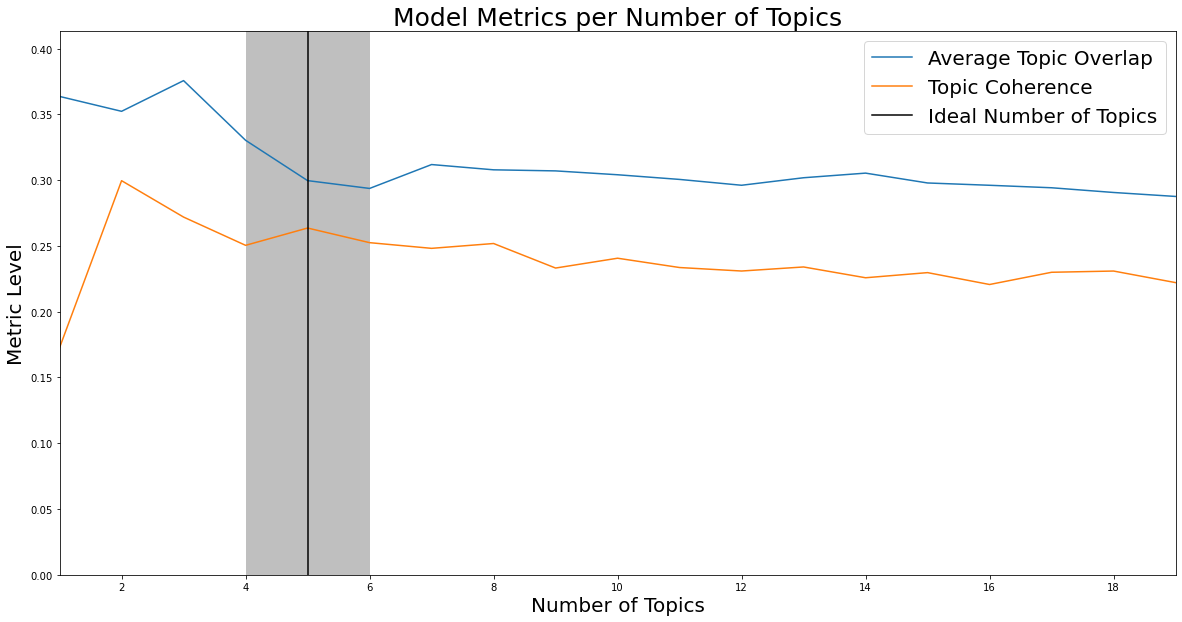

In [8]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('../figures/k_parameter.pdf')
plt.show()   

In [9]:
gensimvis.prepare(LDA_models[5], bow_corpus, dirichlet_dict)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.148699  0.023820       1        1  28.768137
3      0.023853 -0.044019       2        1  25.976510
1      0.316988 -0.027290       3        1  15.499888
4     -0.021757  0.143538       4        1  15.411548
2     -0.170385 -0.096050       5        1  14.343917, topic_info=            Term          Freq          Total Category  logprob  loglift
28        CpCN_1  34824.000000   34824.000000  Default  30.0000  30.0000
22  SizeDipSeg_3  59469.000000   59469.000000  Default  29.0000  29.0000
8   SizeDipSeg_1  59779.000000   59779.000000  Default  28.0000  28.0000
32   Dist2Cent_1  29447.000000   29447.000000  Default  27.0000  27.0000
33         LOH_1  27571.000000   27571.000000  Default  26.0000  26.0000
..           ...           ...            ...      ...      ...      ...
19   Dist2Cent_2   2604.297205   30076.509957   Topic5  -4.4691  -0.5047
34      GCcSeg_5   2083.706769   25805.860006   Topic5  -4.6921  -0.5746
14      SegVal_6   1729.759730   29572.142967   Topic5  -4.8783  -0.8970
39          CN_6    588.449575   11496.085052   Topic5  -5.9565  -1.0304
5          LOH_0   5559.226618  148116.438071   Topic5  -3.7108  -1.3407

[186 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
31        3  0.002851          CN_1
31        4  0.001267          CN_1
31        5  0.995755          CN_1
18        1  0.087971          CN_2
18        2  0.420084          CN_2
...     ...       ...           ...
22        1  0.000168  SizeDipSeg_3
22        2  0.597529  SizeDipSeg_3
22        3  0.400942  SizeDipSeg_3
22        4  0.000135  SizeDipSeg_3
22        5  0.001228  SizeDipSeg_3

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 5, 3])

In [10]:
def plot_top_words(df, title):
    fig = plt.figure(figsize=(30, 16))
    ypos = [0, 0, 0, 1, 1]
    xpos = [0, 2, 4, 1, 3]
    
    word = []
    weights = []
    signature = []

    for topic in lda.show_topics(num_words = 10, formatted=False):

        for w in topic[1]:
            word.append(w[0])
            weights.append(w[1])
            signature.append(topic[0])

        weight_df = pd.DataFrame({
            'Bin' : word,
            'Weight' : weights,
            'Signature' : signature})

    # weight_df = weight_df.sort_values(by=['Bin'])
    
    for i in range(5):
        ax = plt.subplot2grid((2,6), (ypos[i], xpos[i]), colspan=2)
        axdf = weight_df[weight_df['Signature'] == i]
        ax.barh(axdf['Bin'], axdf['Weight'], height=0.7)
        ax.set_title(f"Signature {i + 1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.set_xlim(0, 0.14)
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    
    fig.subplots_adjust(top=0.90, bottom=0.05, wspace=1.1, hspace=0.2)
    plt.savefig('../figures/feature_signature_dist.pdf')
    fig.suptitle(title, fontsize=40)

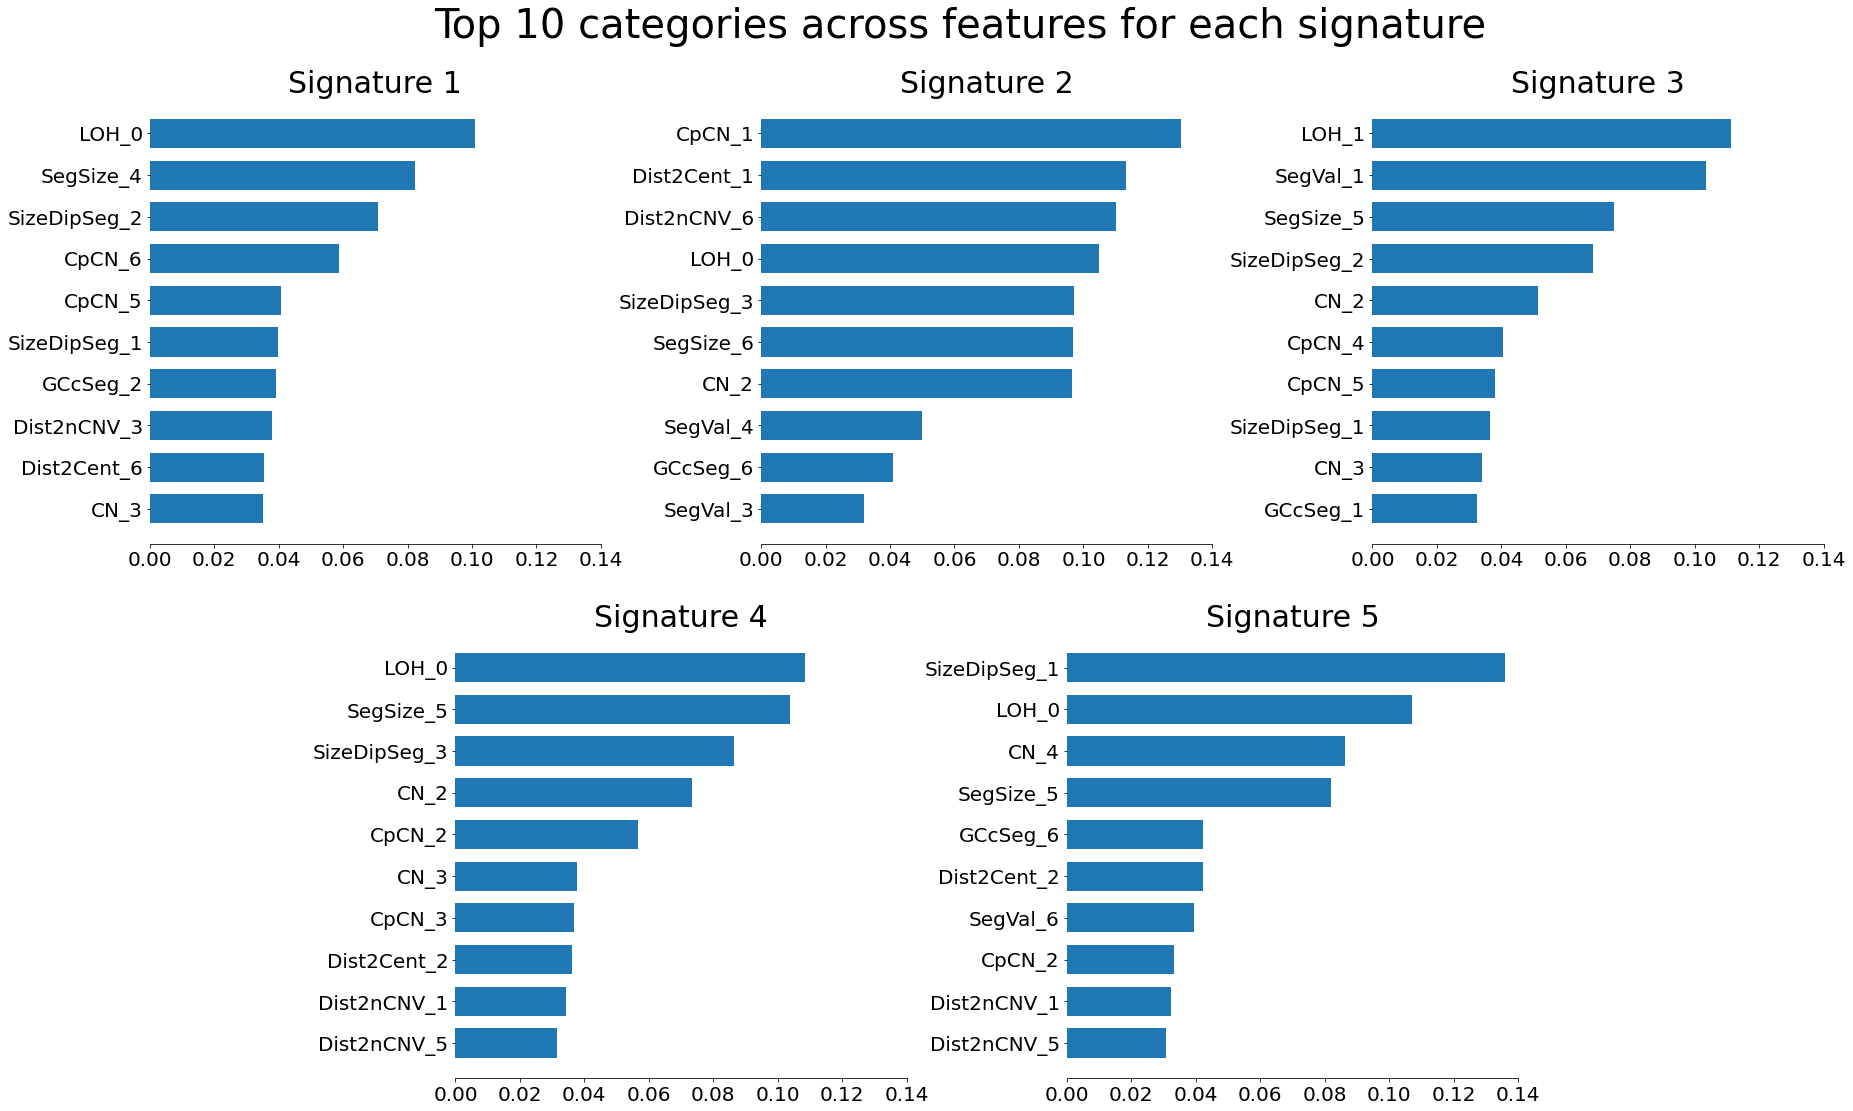

In [11]:
plot_top_words(lda, "Top 10 categories across features for each signature")

In [12]:
def each_topic_distribution(model, specific_signature, title):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey=True)
    axes = axes.flatten()
    features = ["CN", "SegSize", "Dist2Cent", "SegVal", "LOH", "SizeDipSeg", "CpCN", "Dist2nCNV", "GCcSeg"]
    
    word = []
    weights = []
    signatures = []

    topic = lda.show_topics(num_words = 50, formatted=False)
    signature = topic[specific_signature-1]

    for w in signature[1]:
        word.append(w[0])
        weights.append(w[1])
        signatures.append(signature[0])

    weight_df = pd.DataFrame({
        'Bin' : word,
        'Weight' : weights,
        'Signature' : signatures})
    weight_df = weight_df.sort_values(by=['Bin'])
    
    for i in range(9):
        ax = axes[i]
        axdf = weight_df[weight_df['Bin'].str.match(features[i])]
        ax.bar(axdf['Bin'], axdf['Weight'], width=0.7)
        ax.set_title(f"{features[i]}", fontdict={"fontsize": 15})
        ax.set_ylim(0, 0.12)
        ax.tick_params(axis="both", which="major", labelsize=8)
        ax.tick_params(axis='x', labelrotation=90)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    fig.subplots_adjust(hspace=0.85, wspace=0.1)
    fig.savefig(f'../figures/featuredist_signature{specific_signature}.pdf')
    fig.suptitle(title, fontsize=20)

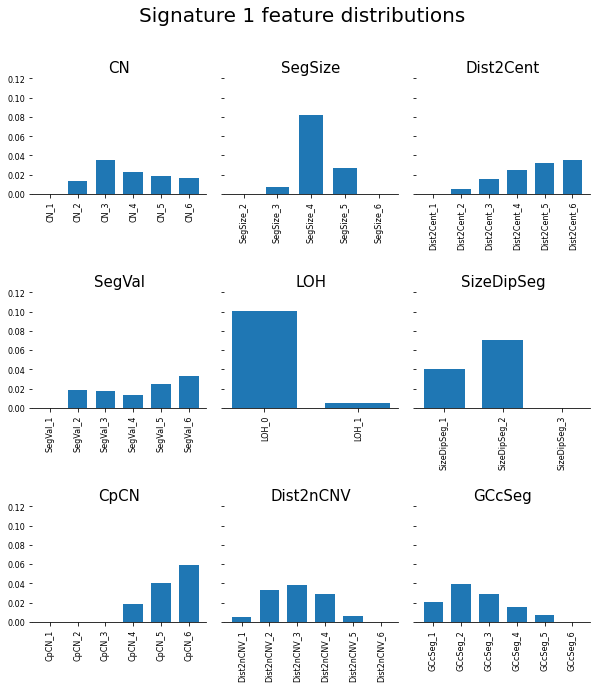

In [13]:
each_topic_distribution(lda, 1, "Signature 1 feature distributions")

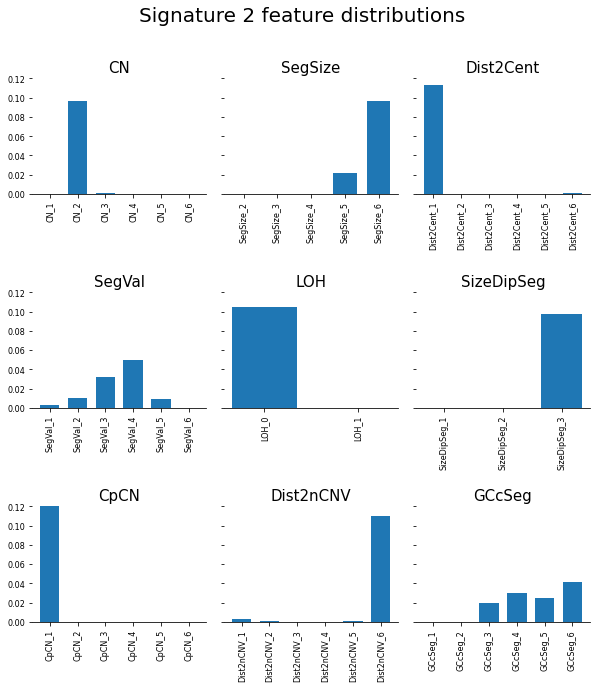

In [14]:
each_topic_distribution(lda, 2, "Signature 2 feature distributions")

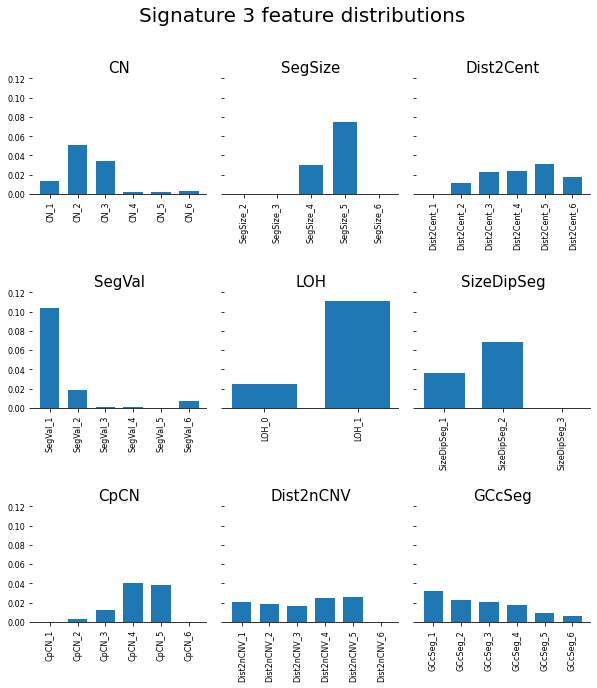

In [15]:
each_topic_distribution(lda, 3, "Signature 3 feature distributions")

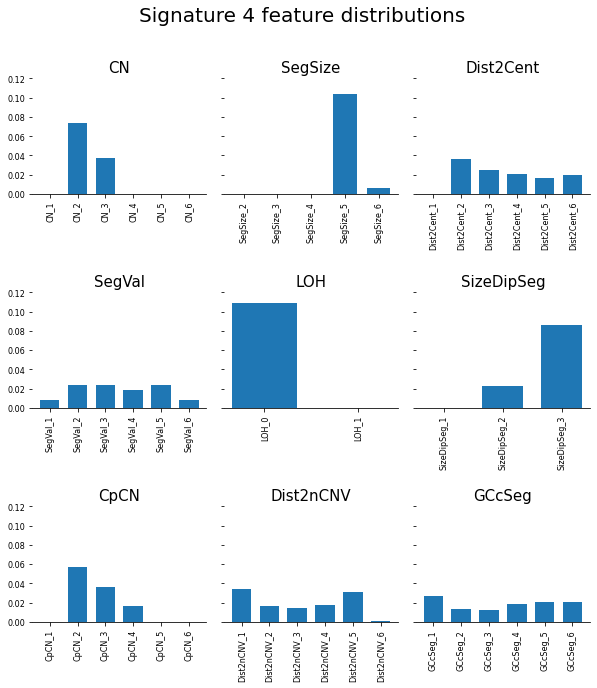

In [16]:
each_topic_distribution(lda, 4, "Signature 4 feature distributions")

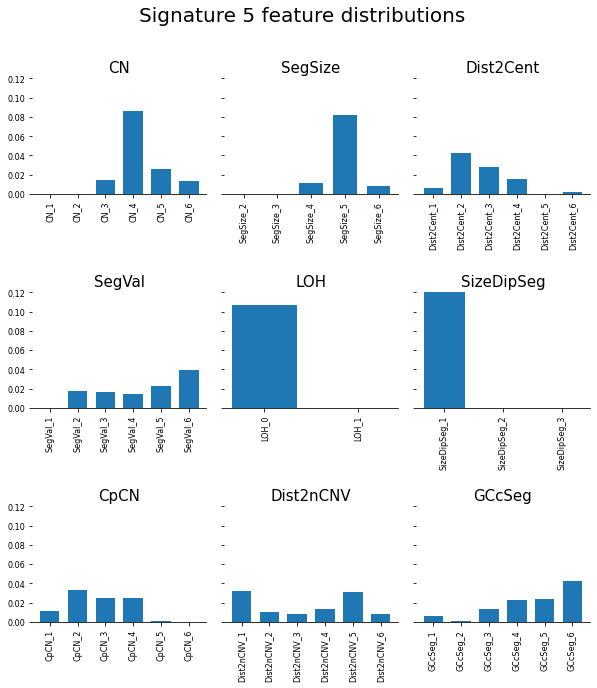

In [17]:
each_topic_distribution(lda, 5, "Signature 5 feature distributions")

In [18]:
def all_signatures(model, title):
    fig, axes = plt.subplots(5, 9, figsize=(40, 25), sharey=True)
    axes = axes.flatten()
    features = ["CN", "SegSize", "Dist2Cent", "SegVal", "LOH", "SizeDipSeg", "CpCN", "Dist2nCNV", "GCcSeg"]
    counter = 0
    palette = list(sns.color_palette("tab10", 9).as_hex())
    
    for topic in lda.show_topics(num_words = 50, formatted=False):
        word = []
        weights = []
        signatures = []

        for w in topic[1]:
            word.append(w[0])
            weights.append(w[1])
            signatures.append(topic[0])

        weight_df = pd.DataFrame({
            'Bin' : word,
            'Weight' : weights,
            'Signature' : signatures})

        weight_df = weight_df.sort_values(by=['Bin'])
    
        for i in range(9):
            ax = axes[i + counter]
            axdf = weight_df[weight_df['Bin'].str.match(features[i])]
            ax.bar(axdf['Bin'], axdf['Weight'], width=0.7, color=palette[i])
            ax.set_title(f"{features[i]}", fontdict={"fontsize": 25})
            ax.set_ylim(0, 0.15)
            ax.tick_params(axis="both", which="major", labelsize=15)
            ax.tick_params(axis='x', labelrotation=90)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=40)
        counter += 9
    
    rows = ['Signature {}'.format(number) for number in ['1', '2', '3', '4', '5']]

    # The worst solution I have ever used
    counter = 0
    axs = []
    for ax in axes:
        if counter == 0 or counter == 9 or counter == 18 or counter == 27 or counter == 36:
            axs.append(ax)
        counter += 1
    for ax, row in zip(axs, rows):
        ax.set_ylabel(row, size = 25)
    
    fig.subplots_adjust(hspace=0.85, top=0.92)
    fig.savefig(f'../figures/all_signatures.pdf')
    fig.suptitle(title, fontsize=40)

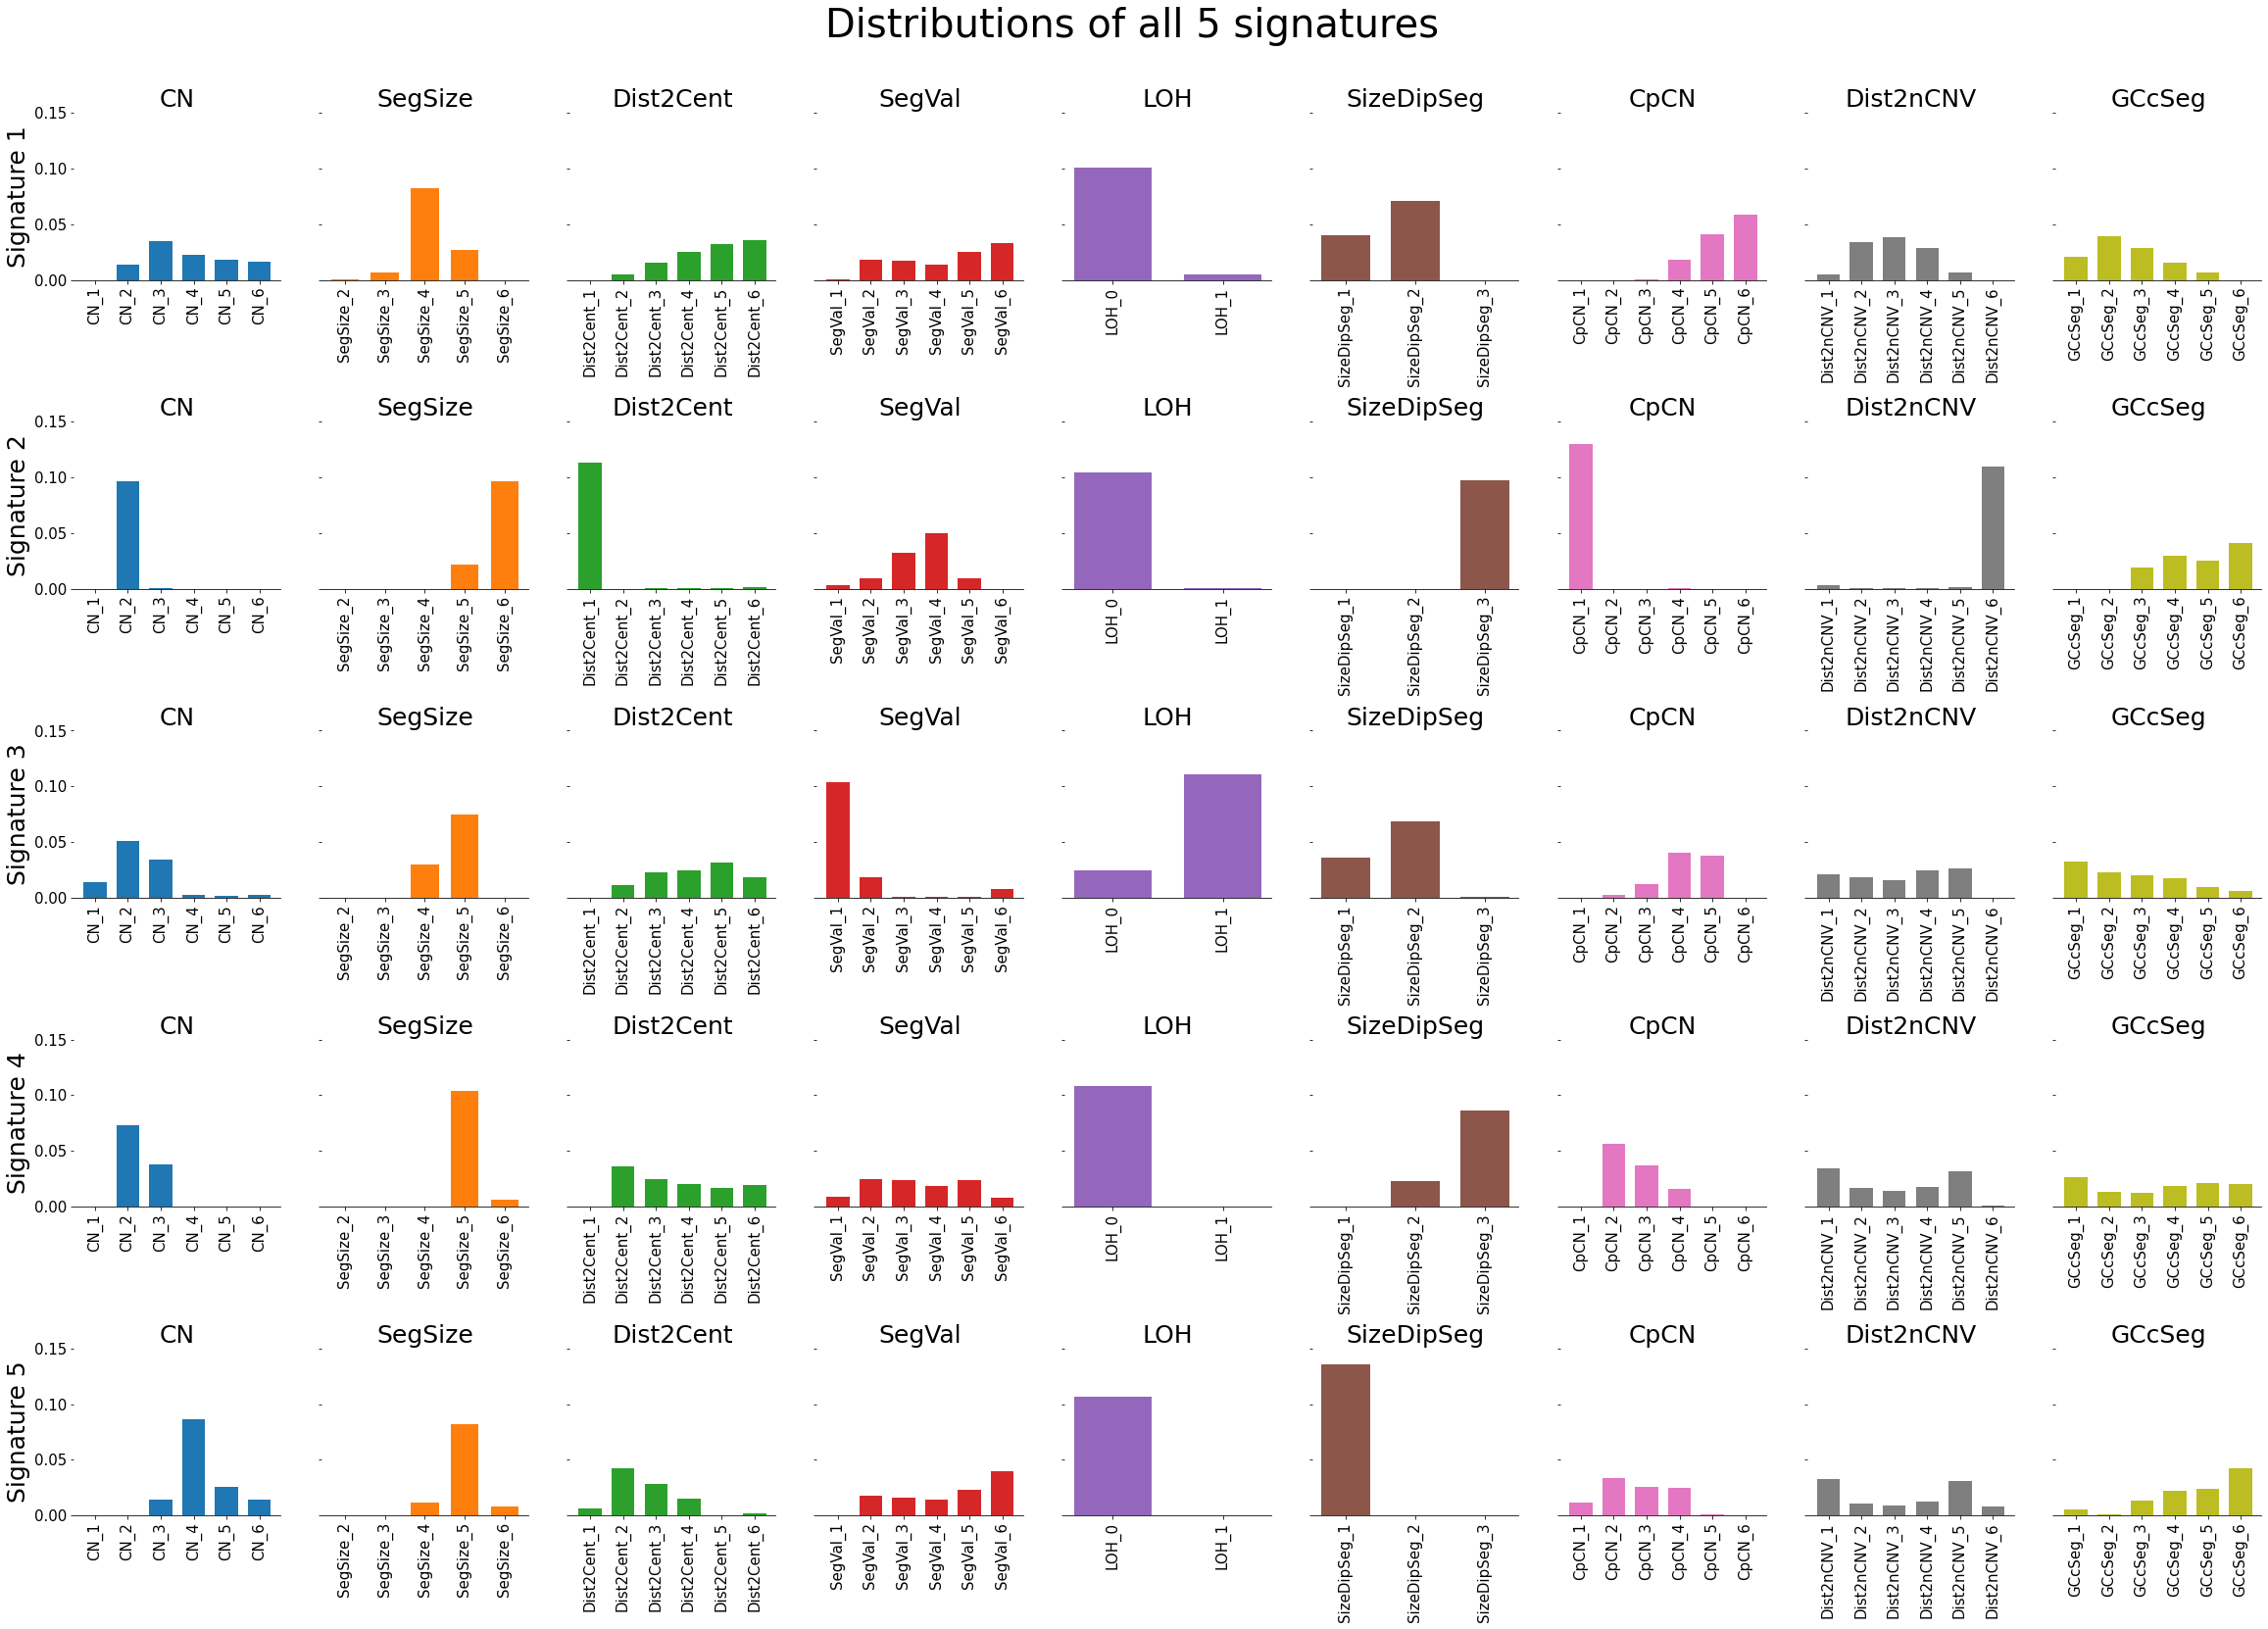

In [19]:
all_signatures(lda, "Distributions of all 5 signatures")

In [ ]:
import matplotlib.colors as mcolors
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda[bow_corpus]):
    topic_weights.append([w for i, w in row_list])
    
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 176035 samples in 0.145s...
[t-SNE] Computed neighbors for 176035 samples in 8.569s...
[t-SNE] Computed conditional probabilities for sample 1000 / 176035
[t-SNE] Computed conditional probabilities for sample 2000 / 176035
[t-SNE] Computed conditional probabilities for sample 3000 / 176035
[t-SNE] Computed conditional probabilities for sample 4000 / 176035
[t-SNE] Computed conditional probabilities for sample 5000 / 176035
[t-SNE] Computed conditional probabilities for sample 6000 / 176035
[t-SNE] Computed conditional probabilities for sample 7000 / 176035
[t-SNE] Computed conditional probabilities for sample 8000 / 176035
[t-SNE] Computed conditional probabilities for sample 9000 / 176035
[t-SNE] Computed conditional probabilities for sample 10000 / 176035
[t-SNE] Computed conditional probabilities for sample 11000 / 176035
[t-SNE] Computed conditional probabilities for sample 12000 / 176035
[t-SNE] Computed conditional probabi

In [ ]:
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)